

GSOC'20 **Task-3** for Deep Learning Algorithms for Muon Momentum Estimation in the CMS Trigger System

by Shubham Shaswat

Email: shaswat.cpp@gmail.com

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import tensorflow.keras as K
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd



TensorFlow 2.x selected.


In [0]:
#download the dataset
!wget https://zenodo.org/record/3164691/files/QG_jets_1.npz


--2020-03-09 13:37:27--  https://zenodo.org/record/3164691/files/QG_jets_1.npz
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106477587 (102M) [application/octet-stream]
Saving to: ‘QG_jets_1.npz’

QG_jets_1.npz       100%[===================>] 101.54M  16.3MB/s    in 7.3s    

2020-03-09 13:37:35 (14.0 MB/s) - ‘QG_jets_1.npz’ saved [106477587/106477587]



In [0]:
#load the data
jet_data = np.load('QG_jets_1.npz')


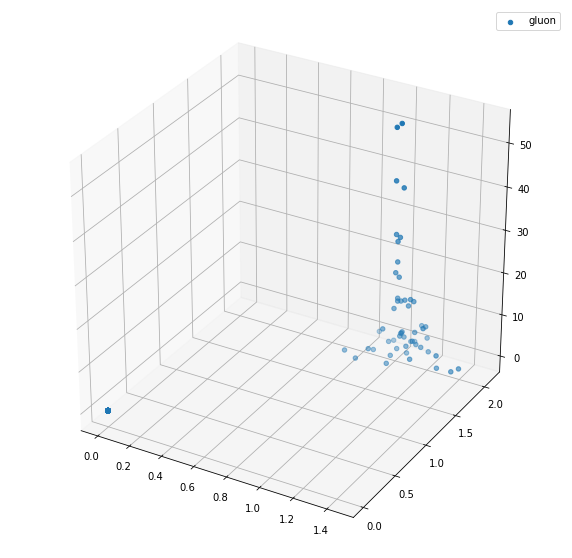

In [0]:
#plot the the jet in 3d

#n is the particle number from th data
n=230
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

x1 = jet_data['X'][n,:,1] #x-axis
y1 = jet_data['X'][n,:,2] #y-axis
z1 = jet_data['X'][n,:,0] #z-axis

#plot the Label
label = 'gluon'
if jet_data['y'][n] == 1:
  label = 'quark'

ax.scatter(x1,y1,z1,label=label)


ax.legend()


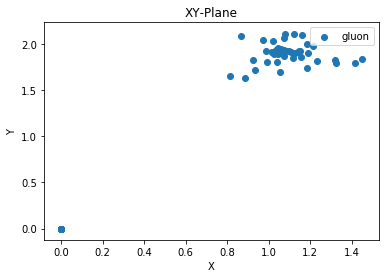

In [0]:
#plot the the jet in XY Plane

#n is the particle number from the data
n=230

x1 = jet_data['X'][n,:,1] #x-axis
y1 = jet_data['X'][n,:,2] #y-axis

#plot the Label
label = 'gluon'
if jet_data['y'][n] == 1:
  label = 'quark'

plt.scatter(x1,y1,label=label)
plt.title('XY-Plane')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()


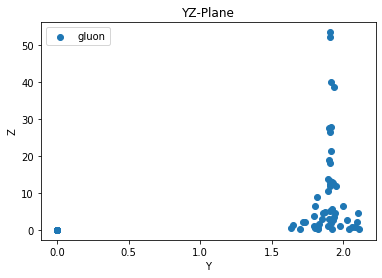

In [0]:
#plot the the jet in YZ Plane

#n is the particle number from the data
n=230

z1 = jet_data['X'][n,:,0] #x-axis
y1 = jet_data['X'][n,:,2] #y-axis

#plot the Label
label = 'gluon'
if jet_data['y'][n] == 1:
  label = 'quark'

plt.scatter(y1,z1,label=label)
plt.title('YZ-Plane')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend()


In [0]:
len(jet_data['y'][jet_data['y'] == 0 ])

50000

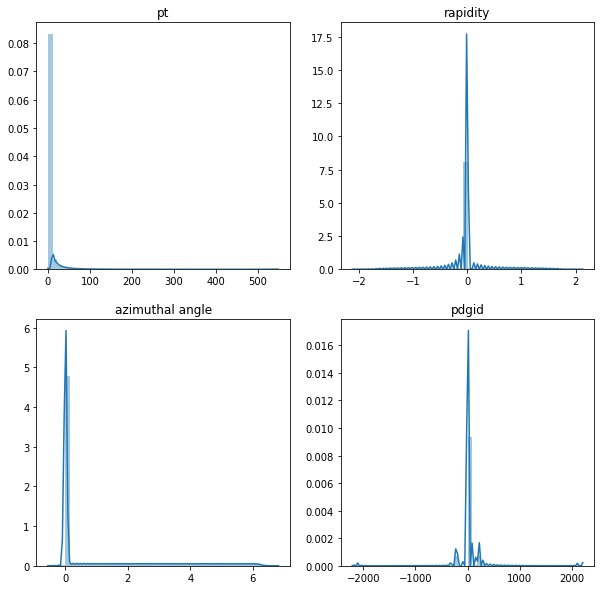

In [0]:
#plot distribution 
import seaborn as sns

labels = ['pt', 'rapidity', 'azimuthal angle','pdgid']
plt.figure(figsize=(10,10))
for i in range(4):
 plt.subplot(2,2,i+1)
 plt.title(labels[i])
 sns.distplot(jet_data['X'][:,:,i])

In [0]:
#min and max of each features

max_0 = np.max(jet_data['X'][:,:,0])
min_0 = np.min(jet_data['X'][:,:,0])

max_1 = np.max(jet_data['X'][:,:,1])
min_1 = np.min(jet_data['X'][:,:,1])

max_2 = np.max(jet_data['X'][:,:,2])
min_2 = np.min(jet_data['X'][:,:,2])

max_3 = np.max(jet_data['X'][:,:,3])
min_3 = np.min(jet_data['X'][:,:,3])

In [0]:
#normalise the features
f_0 = (jet_data['X'][:,:,0]-min_0)/(max_0-min_0)
f_1 = (jet_data['X'][:,:,1]-min_1)/(max_1-min_1)
f_2 = (jet_data['X'][:,:,2]-min_2)/(max_2-min_2)
f_3 = (jet_data['X'][:,:,3]-min_3)/(max_3-min_3)

In [0]:
#expand dims
f_0 = tf.expand_dims(f_0,axis=2)
f_1 = tf.expand_dims(f_1,axis=2)
f_2 = tf.expand_dims(f_2,axis=2)
f_3 = tf.expand_dims(f_3,axis=2)


In [0]:
#concatenate the feature
f = np.concatenate((f_0,f_1,f_2,f_3),axis=-1)

In [0]:
#free space
del f_0
del f_1
del f_2
del f_3


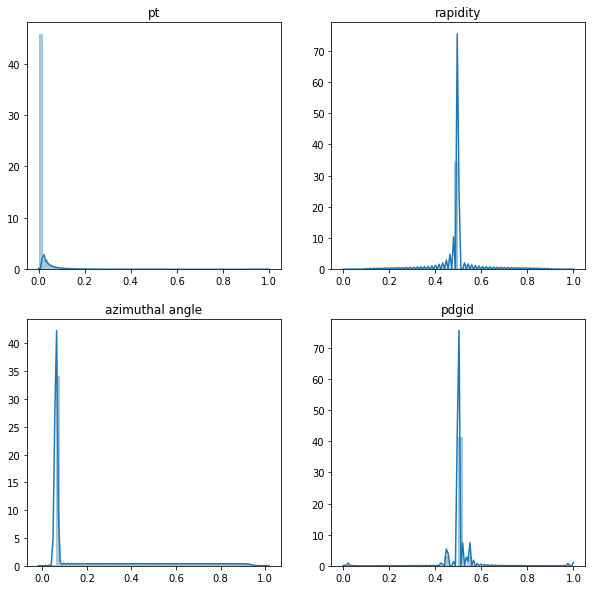

In [0]:
#plot distribution after normalisation
import seaborn as sns

labels = ['pt', 'rapidity', 'azimuthal angle','pdgid']
plt.figure(figsize=(10,10))
for i in range(4):
 plt.subplot(2,2,i+1)
 plt.title(labels[i])
 sns.distplot(f[:,:,i])

In [0]:
lr = 0.01 #learning rate
#loss object and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)

#define loss and accuracy metrics for both train and val data

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [0]:
#defina a train step
@tf.function
def train_step(x, A,y):
  with tf.GradientTape() as tape:
    
    predictions = model(x,A, training=True)
    loss = loss_object(y, predictions)


  gradients = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)



In [0]:
#define a test step
@tf.function
def test_step(x,A, y):
  
    
  predictions = model(x, A,training=False)
  t_loss = loss_object(y, predictions)


  test_loss(t_loss)
  test_accuracy(y, predictions)



In [0]:
import time


#function to train the model
def train(train_dataset,test_dataset,EPOCHS=2):

  acc_plot=[]
  loss_plot=[]
  t_acc=[]
  t_loss=[]

  for epoch in range(EPOCHS):

    #start time
    t0 = time.time()



    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    

    for x,A,y in train_dataset:
     train_step(x,A,y)
    

    for x,A,y in test_dataset:
      test_step(x,A, y)
    

    acc_plot.append(train_accuracy.result()*100)
    loss_plot.append(train_loss.result())
    
   
    t_acc.append(test_accuracy.result()*100)
    t_loss.append(test_loss.result())
    

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, Time {:.4f}  '
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100,
                          time.time()-t0
                          ))
    
  return acc_plot,t_acc,loss_plot,t_loss

In [0]:

from tensorflow.keras import Model

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout,MaxPooling2D,GRUCell,RNN,Layer


"""
The code is copied from the below mentionde URL
credits = https://github.com/SeongokRyu/Graph-neural-networks/blob/master/tutorials/ggnn.ipynb
The code is modified to be comaptible with TF2.0 
"""

#buidling a MPNN Model modeified for binary classification for the jet data

"""
  Parameters:
  -----------------------
  num_nodes : the number of nodes graph have
  input_dim : the nodes features dimension
  output_dim : the output dimension of the nodes
  -----------------------

"""

class MPNN(Model):

  def __init__(self,num_nodes,input_dim,output_dim):
    super(MPNN,self).__init__()

    self.num_nodes = num_nodes
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.dense1 = Dense(output_dim)
    self.gru_cell1 = GRUCell(output_dim) #GRU cell
    self.rnn = RNN(self.gru_cell1)
    self.dense2 = Dense(num_nodes,activation='relu') #Dense layer tp aggregate outputs of the all the nodes
    self.dense3 = Dense(2) #Dense layer for binary classification
    

  def call(self,X,A):

    X = self.dense1(X) 
    _m = tf.matmul(A,X) #messages

    X_total=[]
    for i in range(self.num_nodes):
      mi = tf.expand_dims(_m[:,i,:],1)
      hi = X[:,i,:]
      _h = self.rnn(mi,initial_state=hi)
      X_total.append(tf.expand_dims(_h,1))

    out =tf.concat(X_total,axis=1)
    out = tf.squeeze(out,axis=-1)

    out = self.dense2(out) 
    out = self.dense3(out)
    
    return out



Now,we will prepare the train and test data for our model training.
We will use tensorflow dataset features to produce the input pipline and map the data to procduce a tensor of shape 134 * 134 **A** which is our Adjancy Matrix representing a complete graph.

In [0]:
#split into train and test data,90% train data and 10% test data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(f, jet_data['y'], test_size=0.1, random_state=42)

In [0]:
#define a map fn

def map_fn(x,y):
  A = tf.ones((134,134))
  return x,A,y

In [0]:
#create input pipeline
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.map(map_fn)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_dataset = test_dataset.map(map_fn)
test_dataset = test_dataset.batch(BATCH_SIZE)



In [0]:
test_dataset

<BatchDataset shapes: ((None, 134, 4), (None, 134, 134), (None,)), types: (tf.float64, tf.float32, tf.float64)>

In [0]:
#call the model
model=MPNN(134,4,1) #graph o

In [0]:
#train the model
acc_,acc_t,loss_,loss_t=train(train_dataset=train_dataset,test_dataset=test_dataset,EPOCHS=5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.5178810954093933, Accuracy: 75.02666473388672, Test Loss: 0.4948587715625763, Test Accuracy: 76.45000457763672, Time 407.0778  
Epoch 2, Loss: 0.47976553440093994, Accuracy: 77.63111114501953, Test Loss: 0.47728851437568665, Test Accuracy: 77.51000213623047, Time 253.9784  
Epoch 3, Loss: 0.4755502939224243, Accuracy: 77.86000061035156, Test Loss: 0.4821339547634125, Test Accuracy: 77.52000427246094, Time 251.9413  
Epoch 4, Loss: 0.4738799035549164, Accuracy: 78.0088882446289, Test Los

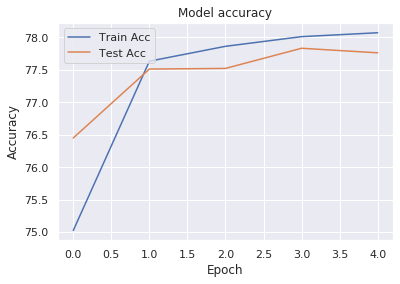

In [0]:
#plot accuracy

plt.plot(acc_)
plt.plot(acc_t)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Test Acc'], loc='upper left')


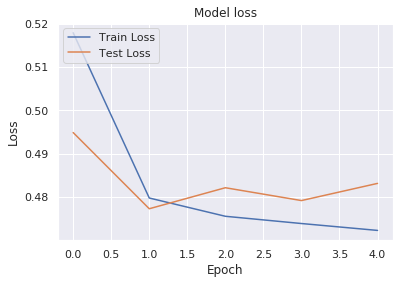

In [0]:
#plot loss
plt.plot(loss_)
plt.plot(loss_t) #mistake I overite loss_t with loss_
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')


In [0]:
#get predictions on test data
A=tf.ones((10000,134,134))
predictions = (model(x_test,A))

In [0]:
#get argmax of predictions
predictions = np.argmax(tf.math.softmax(predictions),axis=1)

In [0]:
#get confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test ,predictions)


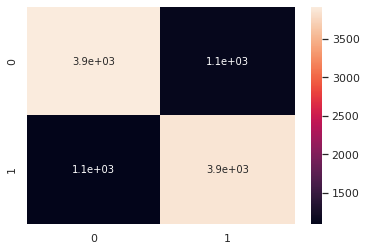

In [0]:
#draw confusion  matrix
sns.set(font_scale=1) # for label size
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 10}) # font size

Notes:

I trainde the model for 5 epocsh with Adam optimizer with learning rate  = 0.1
The model is trained on only one "QG_jet data" but it can be trained on other data altogether.However it will take much longer time to train.

In this, We assume that the jet data is a complete graph of 134 nodes,each nodes having 4 features.

But,for future we could have a learnable adjancey matric **A**  based on the paper [Neural Message Passing for Jet Physics
](https://dl4physicalsciences.github.io/files/nips_dlps_2017_29.pdf)